Compute the normalised HSIC for weights of edges. This normalised statistic corresponds to distance correlation (https://arxiv.org/pdf/1606.07892.pdf): $\rho_{XY} = \frac{\|C_{XY}\|^2_{HS}}{\|C_{XX}\|_{HS}\|C_{YY}\|_{HS}}$

Moreover, in this notebook we precompute the kernel matrices for each continent and each goal.

# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to continents.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [2]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [3]:
# read amended csv file
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [4]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4) # removing Micronesia
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6) # removing Micronesia
continents['World'] = continents['World'].drop(index=170) # removing Micronesia
continents.drop(['Northern Africa', 'Southern Africa', 'North America', 'Australia and New Zealand'], axis=1, inplace=True)


In [5]:
continents

Eastern Africa             Middle Africa Western Africa  \
0          Burundi                    Angola          Benin   
1          Comoros                  Cameroon   Burkina Faso   
2         Djibouti  Central African Republic  Cote d'Ivoire   
3          Eritrea                      Chad    Gambia, The   
4         Ethiopia               Congo, Rep.          Ghana   
..             ...                       ...            ...   
171            NaN                       NaN            NaN   
172            NaN                       NaN            NaN   
173            NaN                       NaN            NaN   
174            NaN                       NaN            NaN   
175            NaN                       NaN            NaN   

    Sub-Saharan Africa            Africa            Caribbean Central America  \
0              Burundi           Algeria  Antigua and Barbuda          Belize   
1              Comoros  Egypt, Arab Rep.         Bahamas, The      Costa Rica   
2             Djibouti           Morocco             Barbados     El Salvador   
3              Eritrea           Tunisia                 Cuba       Guatemala   
4             Ethiopia           Burundi             Dominica        Honduras   
..                 ...               ...                  ...             ...   
171                NaN               NaN                  NaN             NaN   
172                NaN               NaN                  NaN             NaN   
173                NaN               NaN                  NaN             NaN   
174                NaN               NaN                  NaN             NaN   
175                NaN               NaN                  NaN             NaN   

    South America Latin America and the Caribbean             Americas  ...  \
0       Argentina             Antigua and Barbuda  Antigua and Barbuda  ...   
1         Bolivia                    Bahamas, The         Bahamas, The  ...   
2          Brazil                        Barbados             Barbados  ...   
3           Chile                            Cuba                 Cuba  ...   
4        Colombia                        Dominica             Dominica  ...   
..            ...                             ...                  ...  ...   
171           NaN                             NaN                  NaN  ...   
172           NaN                             NaN                  NaN  ...   
173           NaN                             NaN                  NaN  ...   
174           NaN                             NaN                  NaN  ...   
175           NaN                             NaN                  NaN  ...   

    Western Asia             Asia  Eastern Europe Northern Europe  \
0        Armenia       Kazakhstan         Belarus         Denmark   
1     Azerbaijan  Kyrgyz Republic        Bulgaria         Estonia   
2        Bahrain       Tajikistan  Czech Republic         Finland   
3         Cyprus     Turkmenistan         Hungary         Iceland   
4        Georgia       Uzbekistan          Poland         Ireland   
..           ...              ...             ...             ...   
171          NaN              NaN             NaN             NaN   
172          NaN              NaN             NaN             NaN   
173          NaN              NaN             NaN             NaN   
174          NaN              NaN             NaN             NaN   
175          NaN              NaN             NaN             NaN   

            Southern Europe Western Europe          Europe  \
0                   Albania        Austria         Belarus   
1    Bosnia and Herzegovina        Belgium        Bulgaria   
2                   Croatia         France  Czech Republic   
3                    Greece        Germany         Hungary   
4                     Italy     Luxembourg          Poland   
..                      ...            ...             ...   
171                     NaN            NaN             NaN   


We generate a list for all unique targets with their corresponding indicators. 

In [6]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [7]:
#check 
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [8]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [9]:
#check 
print(dict_goals['1'])

['1.2', '1.3', '1.1']


## Data preparation

Since we will work with groupings of countries according to continents, we prepare the data in the following way. We create a dictionary with continents as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

Moreover, we create a similar second dictionary, such that the entries of the 17-vector of each continent corresponds to the Kernel matrix of such SDG (considered here as a variable). This kernel matrices are computed using a Gaussian kernel with kernel bandwith computed using the median heuristic; and where the independent samples of a variable (SDG) $X^j$ correspond to the different countries of such continent.

In [10]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [11]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [12]:
# data preparation
continents_prep_g = {}
continents_prep_g_K = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(17, dtype=object)
    continents_prep_g_K[continent] = np.empty(17, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))
        
        g_array = np.asarray(g_list)
        continents_prep_g[continent][g] = g_array
        
        K_matrix = pairwise_kernels(g_array, metric='rbf', gamma=0.5/(width(g_array)**2))
        continents_prep_g_K[continent][g] = K_matrix

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

Africa
Caribbean
Central America
South America


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

Latin America and the Caribbean
Americas
Central and Eastern Asia


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

South-eastern Asia
Southern Asia
Western Asia
Asia


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

Eastern Europe
Northern Europe
Southern Europe


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

World


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

In [13]:
# save this data
f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g.pkl', 'wb')
pickle.dump(continents_prep_g, f)
f.close()

f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g_K.pkl', 'wb')
pickle.dump(continents_prep_g_K, f)
f.close()


In [13]:
# CHECKPOINT
continents_prep_g = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g.pkl', 'rb'))
continents_prep_g_K = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g_K.pkl', 'rb'))

## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [14]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [15]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [16]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [18]:
def dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat_found, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables. Using Monte Carlo approximation.
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha critical value
    Bind = np.sum(stat_found==statistics_sort) + int(np.ceil((1-alpha)*(n_perms+1)))
    critical_value = statistics_sort[Bind]
    
    return critical_value

In [20]:
def joint_independence_test_MC(k_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    k_list: list of Kernel matrices for each variable, each having dimensions (n_samples, n_samples)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    
    Returns:
    reject: 1 if null rejected, 0 if null not rejected
    
    """
    
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    
    # statistic and threshold
    stat = dHSIC(k_list)
    critical_value = dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat, n_perms, alpha) 
    
    reject = int(stat > critical_value)
    
    return reject

## Pairwise HSIC implementation with normalisation

In [19]:
def HSIC_normalised_pairwise(group, groups_data, iterable):
    """
    Perform the independence test with HSIC for all possible pairwise combinations. If null hypothesis
    is rejected, compute the normalised HSIC statistic and set this as the weight of the edge between
    both variables (nodes of the graph).
    """
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to normalised HSIC
    Adj = np.eye(K)  #initialize KxK adjacency matrix 
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible 2-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, 2))   
    
    #compute individual HSIC_XX
    HSIC_XX_sqrt = []
    for i in indexes:
        k_list_XX = list((group_arr[i], group_arr[i]))
        HSIC_XX = dHSIC(k_list_XX)
        HSIC_XX_sqrt.append(np.sqrt(HSIC_XX))
    
    for comb in g_combinations: 
        #create k_list[i] = Kernel from observed data for variable comb[i]
        k_list = list((group_arr[comb[0]], group_arr[comb[1]]))
        
        HSIC_XY = dHSIC(k_list)
        critical_value = dHSIC_permutation_MC(k_list, k_list[0].shape[0], 2, HSIC_XY)
        
        if HSIC_XY > critical_value:
            HSIC_norm = HSIC_XY/(HSIC_XX_sqrt[comb[0]]*HSIC_XX_sqrt[comb[1]])
            Adj[comb[0], comb[1]] = HSIC_norm
            Adj[comb[1], comb[0]] = HSIC_norm
            
        
    return Adj

### Experiment on Goal level

In [20]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
n_labels = {}
for i in range(17):
    n_labels[i] = i+1

In [22]:
Adj_e = HSIC_normalised_pairwise('Europe', continents_prep_g_K, goals)

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


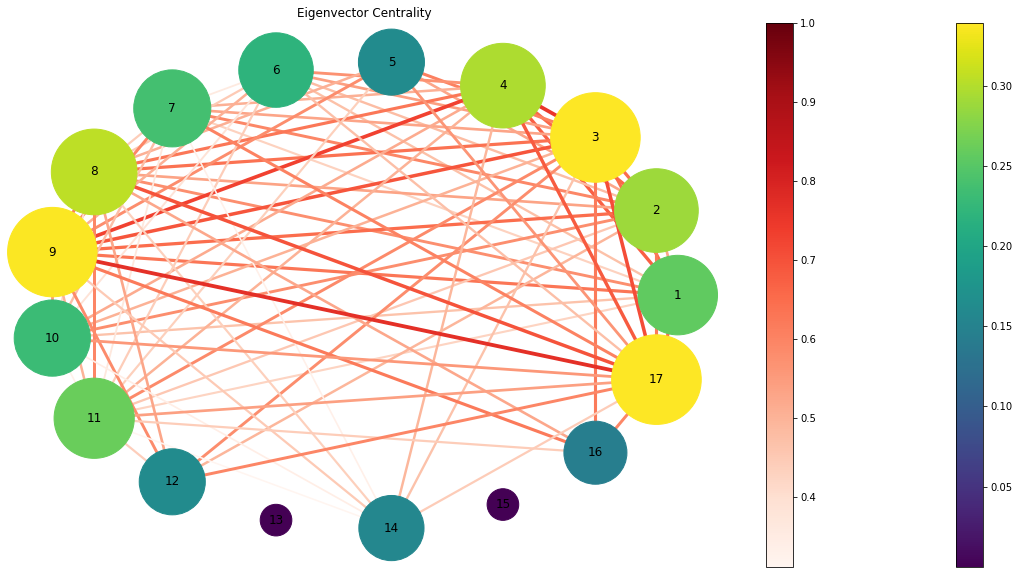

In [23]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_e)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [24]:
Adj_as = HSIC_normalised_pairwise('Asia', continents_prep_g_K, goals)

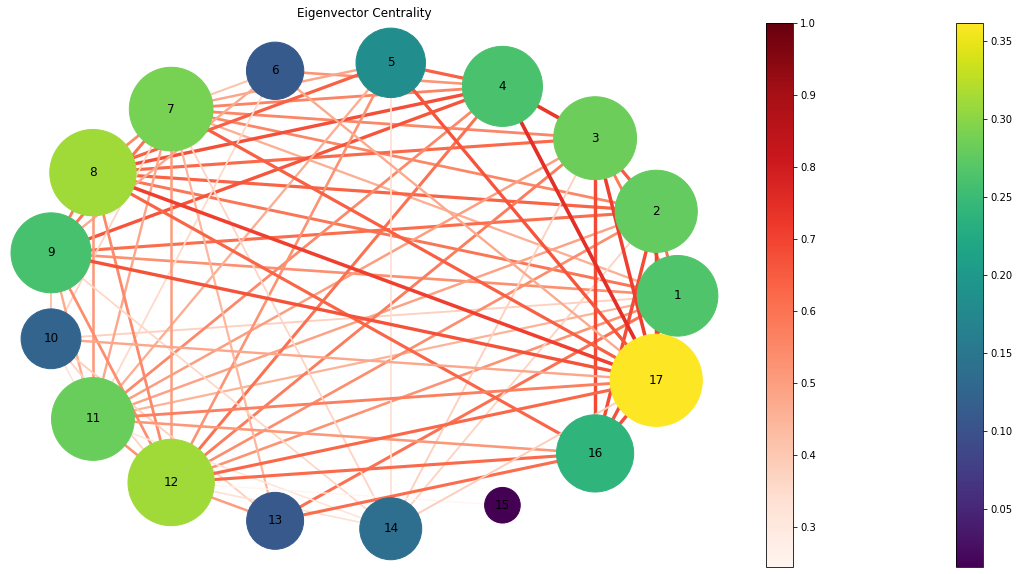

In [25]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_as)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [26]:
Adj_af = HSIC_normalised_pairwise('Africa', continents_prep_g_K, goals)

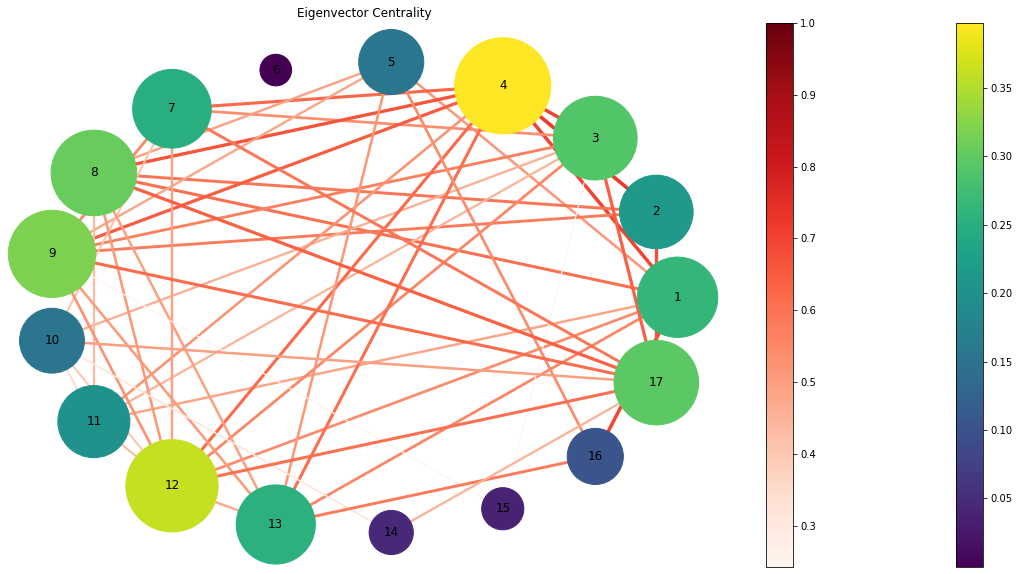

In [27]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_af)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G, weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [28]:
Adj_am = HSIC_normalised_pairwise('Americas', continents_prep_g_K, goals)

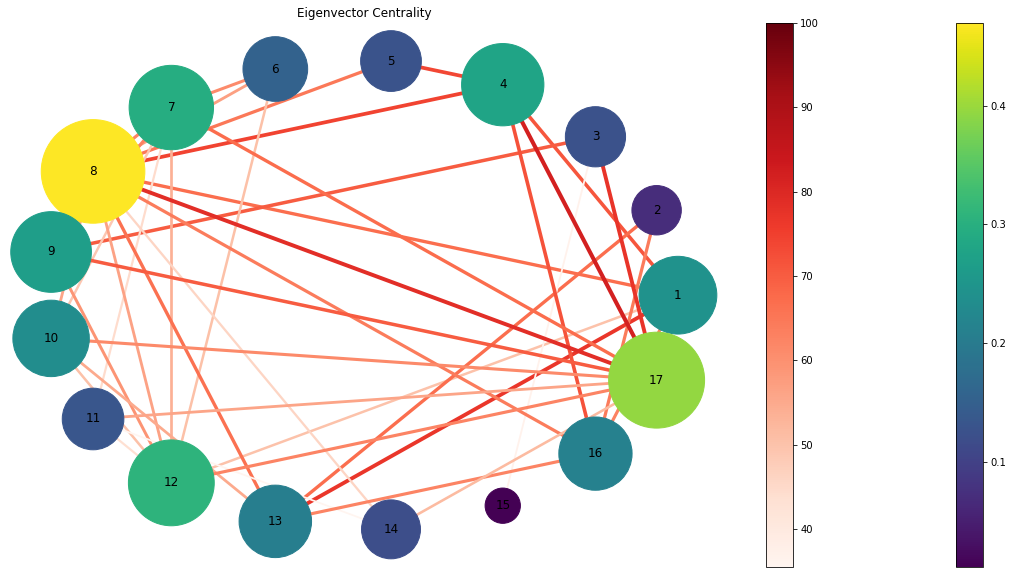

In [29]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_am)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"]*100 for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [30]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_e.pkl', 'wb')
pickle.dump(Adj_e, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_as.pkl', 'wb')
pickle.dump(Adj_as, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_af.pkl', 'wb')
pickle.dump(Adj_af, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_am.pkl', 'wb')
pickle.dump(Adj_am, hs)
hs.close()

In [ ]:
# CHECKPOINT
Adj_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_e.pkl', 'rb'))
Adj_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_as.pkl', 'rb'))
Adj_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_af.pkl', 'rb'))
Adj_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_am.pkl', 'rb'))

## Algorithm for performing all possible independence tests with dHSIC

In [21]:
def dHSIC_links_MC(group, groups_data, iterable, stop_after_2=False, n_perms=5000, alpha=0.05):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create k_list[i] = Kernel from observed data for variable comb[i]
            k_list = []
            for i in range(d):
                k_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)
            reject = joint_independence_test_MC(k_list, n_perms, alpha)   
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination <d, then we should not consider the combinations involving 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

## Experiments on Goal level

Run the above algorithm for finding the high-order dependencies among SDGs in the lowest possible order, ie. starting from pariwise dependencies to d-dependencies.

We do this for the different continents in our dataset and save the results.

In [22]:
edges_e, Adj2_e = dHSIC_links_MC('Europe', continents_prep_g_K, goals, alpha=0.001)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  38
combinations:  3
number of combinations available:  294
Edges found with  3 nodes:  25
combinations:  4
number of combinations available:  422
Edges found with  4 nodes:  23
combinations:  5
number of combinations available:  353
Edges found with  5 nodes:  9
combinations:  6
number of combinations available:  171
Edges found with  6 nodes:  2
combinations:  7
number of combinations available:  38
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  1
Edges found with  8 nodes:  0


In [24]:
edges_af, Adj2_af = dHSIC_links_MC('Africa', continents_prep_g_K, goals, alpha=0.001)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  8
combinations:  3
number of combinations available:  569
Edges found with  3 nodes:  42
combinations:  4
number of combinations available:  1290
Edges found with  4 nodes:  46
combinations:  5
number of combinations available:  1723
Edges found with  5 nodes:  17
combinations:  6
number of combinations available:  1342
Edges found with  6 nodes:  0
combinations:  7
number of combinations available:  569
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  109
Edges found with  8 nodes:  0
combinations:  9
number of combinations available:  5
Edges found with  9 nodes:  0


In [25]:
edges_as, Adj2_as = dHSIC_links_MC('Asia', continents_prep_g_K, goals, alpha=0.001)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  31
combinations:  3
number of combinations available:  344
Edges found with  3 nodes:  68
combinations:  4
number of combinations available:  385
Edges found with  4 nodes:  23
combinations:  5
number of combinations available:  258
Edges found with  5 nodes:  1
combinations:  6
number of combinations available:  100
Edges found with  6 nodes:  0
combinations:  7
number of combinations available:  19
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  1
Edges found with  8 nodes:  0


In [26]:
edges_am, Adj2_am = dHSIC_links_MC('Americas', continents_prep_g_K, goals, alpha=0.001)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  10
combinations:  3
number of combinations available:  547
Edges found with  3 nodes:  38
combinations:  4
number of combinations available:  1269
Edges found with  4 nodes:  63
combinations:  5
number of combinations available:  1762
Edges found with  5 nodes:  65
combinations:  6
number of combinations available:  1433
Edges found with  6 nodes:  9
combinations:  7
number of combinations available:  715
Edges found with  7 nodes:  6
combinations:  8
number of combinations available:  198
Edges found with  8 nodes:  0
combinations:  9
number of combinations available:  24
Edges found with  9 nodes:  0
combinations:  10
number of combinations available:  1
Edges found with  10 nodes:  0


In [36]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Europe.pkl', 'wb')
pickle.dump(edges_e, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Asia.pkl', 'wb')
pickle.dump(edges_as, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Africa.pkl', 'wb')
pickle.dump(edges_af, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Americas.pkl', 'wb')
pickle.dump(edges_am, hs)
hs.close()

In [1]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_e.pkl', 'wb')
pickle.dump(Adj2_e, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_as.pkl', 'wb')
pickle.dump(Adj2_as, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_af.pkl', 'wb')
pickle.dump(Adj2_af, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_am.pkl', 'wb')
pickle.dump(Adj2_am, hs)
hs.close()

NameError: name 'pickle' is not defined

In [ ]:
# CHECKPOINT
edges_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Europe.pkl', 'rb'))
edges_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Asia.pkl', 'rb'))
edges_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Africa.pkl', 'rb'))
edges_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Americas.pkl', 'rb'))

In [ ]:
# CHECKPOINT
Adj2_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_e.pkl', 'rb'))
Adj2_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_as.pkl', 'rb'))
Adj2_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_af.pkl', 'rb'))
Adj2_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_am.pkl', 'rb'))

## Visualisation

In [37]:
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

In [41]:
from hypernetx.algorithms.s_centrality_measures import *

### Europe

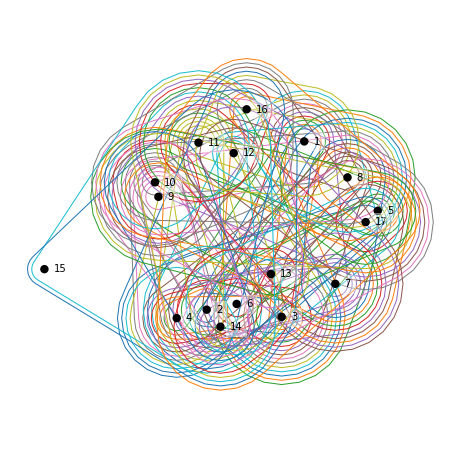

In [39]:
#hypergraph
He = hnx.Hypergraph(edges_e)
hnx.draw(He, with_edge_labels=False)

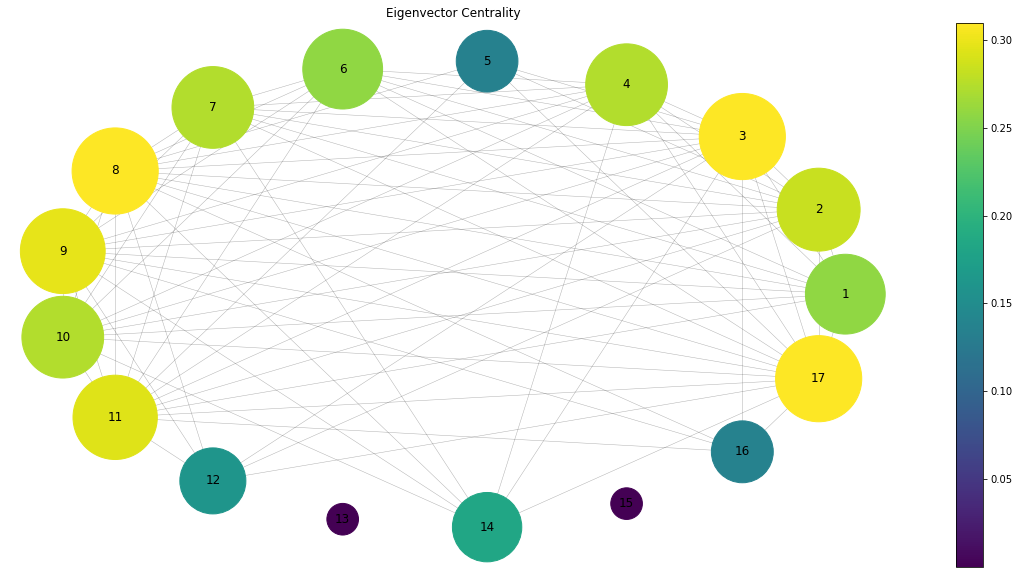

In [40]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_e)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [42]:
centr_E = s_betweenness_centrality(He, s=1, normalized=True)

In [43]:
centr_E

{1: 0.006902726902726905,
 2: 0.007464387464387463,
 3: 0.006039886039886041,
 4: 0.0062163497877783585,
 5: 0.007212047212047211,
 6: 0.0074643874643874645,
 7: 0.00732193732193732,
 8: 0.00644281644281644,
 9: 0.008146403860689575,
 10: 0.007464387464387464,
 11: 0.008909820338391767,
 12: 0.00745043316471888,
 13: 0.004066418590228113,
 14: 0.0070628137294803965,
 15: 0.007895226466655041,
 16: 0.008909820338391767,
 17: 0.008562416419559274,
 18: 0.00771614628757486,
 19: 0.00938688295831153,
 20: 0.00687501211310735,
 21: 0.008909820338391767,
 22: 0.008042328042328043,
 23: 0.00479040359992741,
 24: 0.007739702977798216,
 25: 0.00900139542996686,
 26: 0.009503459503459504,
 27: 0.009387755102040818,
 28: 0.008539159253444967,
 29: 0.010025001453572883,
 30: 0.007080943747610414,
 31: 0.00765655860893956,
 32: 0.005066582447534829,
 33: 0.009503459503459504,
 34: 0.006355698974746596,
 35: 0.007718762718762718,
 36: 0.008042328042328042,
 37: 0.007859177859177858,
 38: 0.006908831

### Asia

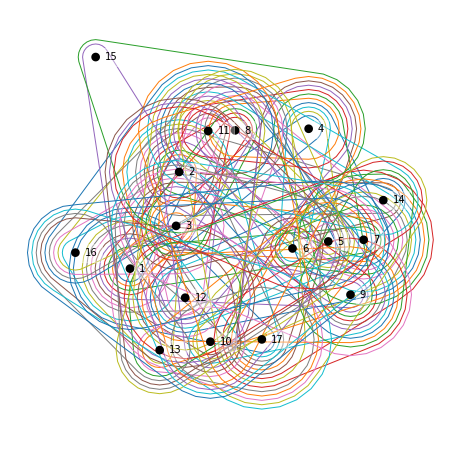

In [44]:
#hypergtraph
Has = hnx.Hypergraph(edges_as)
hnx.draw(Has, with_edge_labels=False)

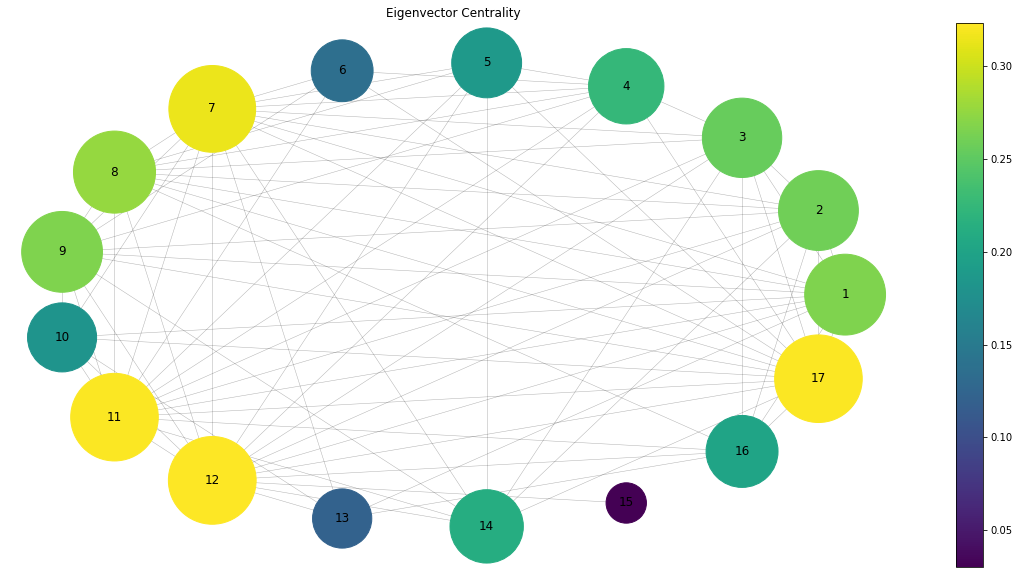

In [46]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_as)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Africa

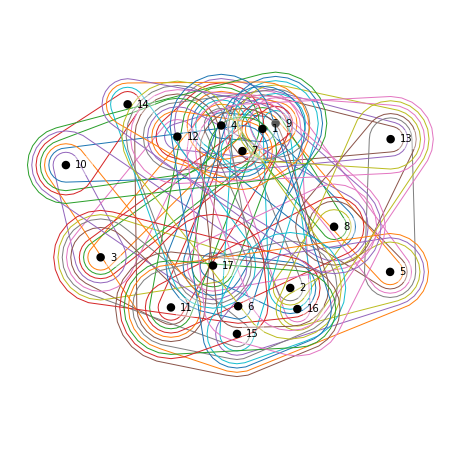

In [47]:
#hypergraph
Haf = hnx.Hypergraph(edges_af)
hnx.draw(Haf, with_edge_labels=False)

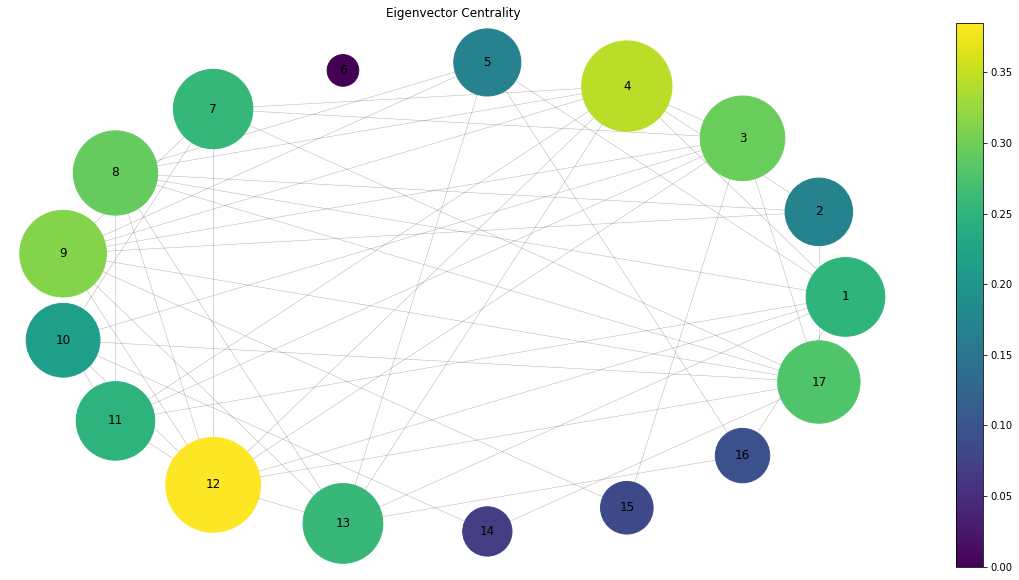

In [48]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_af)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Americas

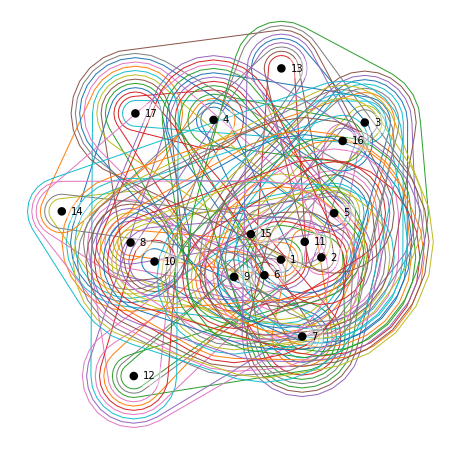

In [49]:
#hypergraph
Ham = hnx.Hypergraph(edges_am)
hnx.draw(Ham, with_edge_labels=False)

In [291]:
Ham.nodes

17

In [280]:
Ham.incidence_matrix().toarray()[-1,:]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0], dtype=int64)

In [281]:
for i in Ham.nodes:
    print(i)

1
4
8
12
13
16
2
3
9
15
17
5
6
7
10
11
14


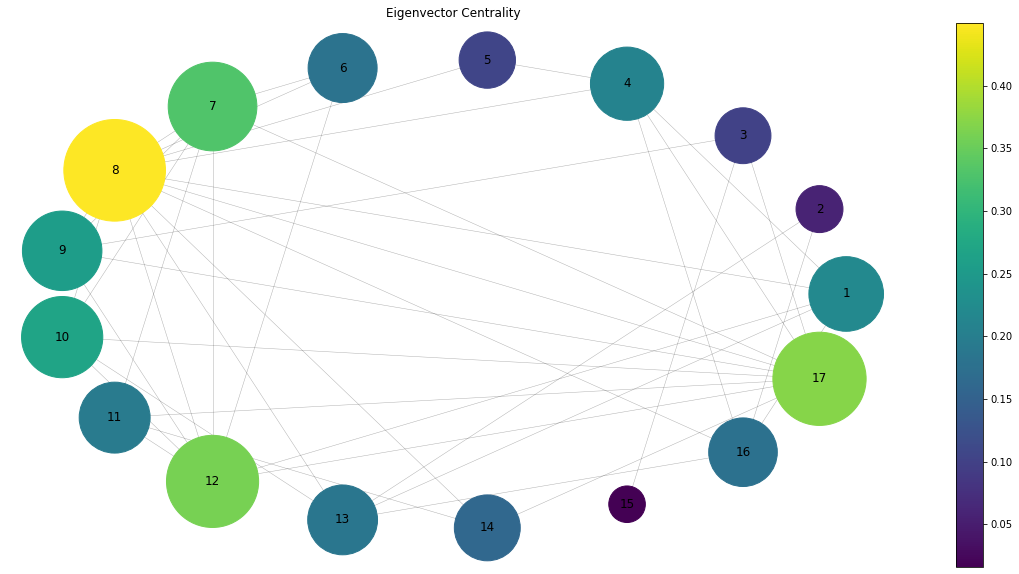

In [50]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_am)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

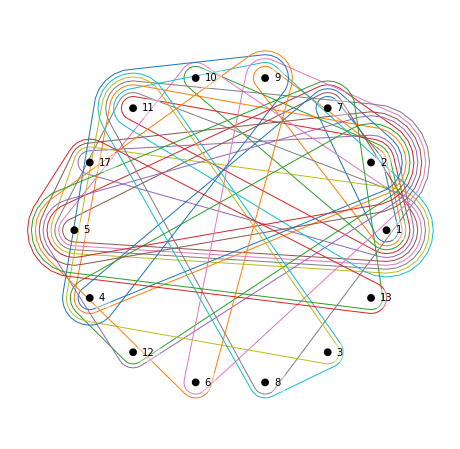

In [51]:
Ham_restrict_edges3 = Ham.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==3))
hnx.draw(Ham_restrict_edges3, pos=nx.circular_layout(Ham_restrict_edges3), with_edge_labels=False)

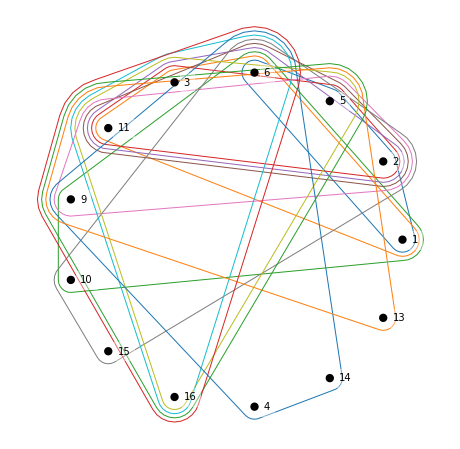

In [52]:
Ham_restrict_edges4 = Ham.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==4))
hnx.draw(Ham_restrict_edges4, pos=nx.circular_layout(Ham_restrict_edges4),with_edge_labels=False)

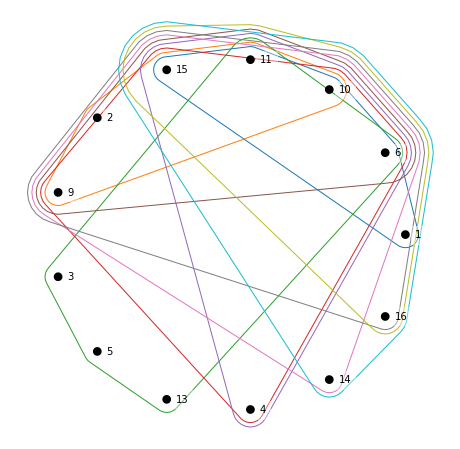

In [53]:
Ham_restrict_edges5 = Ham.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==5))
hnx.draw(Ham_restrict_edges5, pos=nx.circular_layout(Ham_restrict_edges5), with_edge_labels=False)

# Community detection

In [78]:
import pygenstability as pgs
from pygenstability import plotting

In [79]:
def get_laplacian(H):
    
    """ Construct Laplacian for HyperGraph H
    
    Arguments
    H : Hypernetx hypergraph object
    
    """

    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T,incidence)
    A = np.matmul(incidence,incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)),incidence.T))

    # defining transition matrix
    L = R - A
    np.fill_diagonal(L,0)
    np.fill_diagonal(L,-np.sum(L,axis=0)[:,None])
    L
    
    return L
  
def get_transition_matrix(H):
    
    """ Construct Laplacian for HyperGraph H
    
    Arguments
    H : Hypernetx hypergraph object
    
    """

    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T,incidence)
    A = np.matmul(incidence,incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)),incidence.T))

    # defining transition matrix
    T = R - A
    np.fill_diagonal(T,0)
    T = T/np.sum(T,axis=0)[:,None]
    
    return T

def get_adjacency(H):
    
    """ Construct Laplacian for HyperGraph H
    
    Arguments
    H : Hypernetx hypergraph object
    
    """

    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T,incidence)
    A = np.matmul(incidence,incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)),incidence.T))

    # defining transition matrix
    adj = R - A
    np.fill_diagonal(adj,0)

    
    return adj

## Clauset-Newman-Moore greedy modularity

In [80]:
from networkx.algorithms.community import greedy_modularity_communities

In [213]:
def plot_communities_nx(graph, partitions, k_star, pos):
    
    comm = dict()
    for i in range(17):
        for j in range(k_star):
            if i in partitions[j]:
                comm[i] = j
    
    cmap = cm.get_cmap('gist_rainbow', max(comm.values()) + 1)
    plt.figure(figsize=(20, 10))  
    plt.axis('off')
    nx.draw_networkx_nodes(graph, pos, node_size=3000, cmap=cmap, node_color=list(comm.values()))
    labels=nx.draw_networkx_labels(graph,pos, labels=n_labels)
    nx.draw_networkx_edges(graph, pos, width = 0.5, alpha=0.3)
    plt.show(graph)
    

The optimal number k* of communities is 4


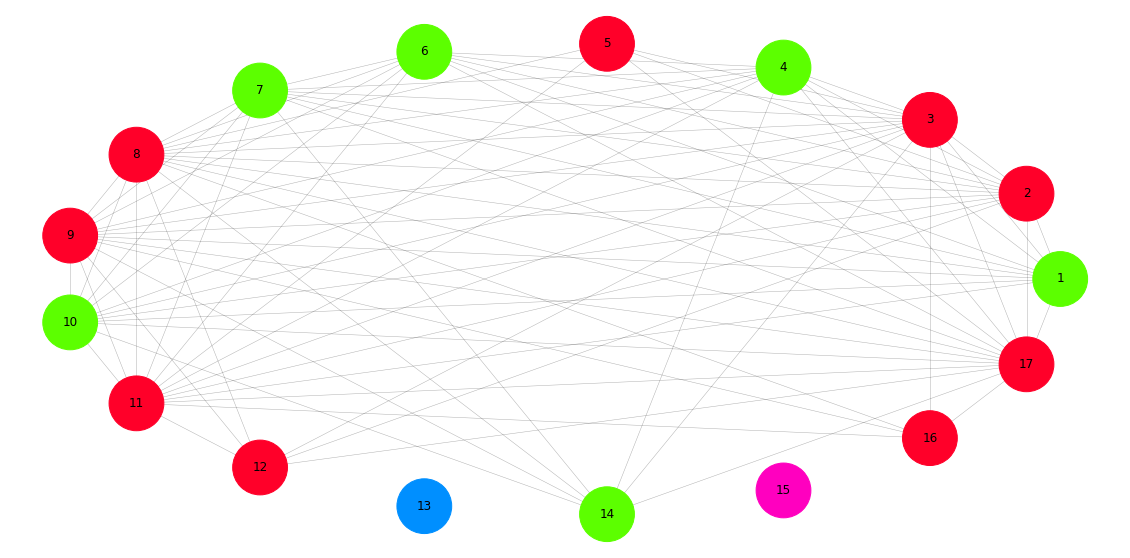

In [214]:
#Compute the greedy modularity maximisation and get the partition of the graph
G_e = nx.Graph(Adj2_e)
pos_e = nx.circular_layout(G_e)
c_e = list(greedy_modularity_communities(G_e))  
k_star_e = len(c_e)    #get the number of communities
print('The optimal number k* of communities is', k_star_e)

partitions_e = [list(x) for x in c_e]  #create an array with lists of the nodes in each community

#plot
plot_communities_nx(G_e, partitions_e, k_star_e, pos_e)

The optimal number k* of communities is 3


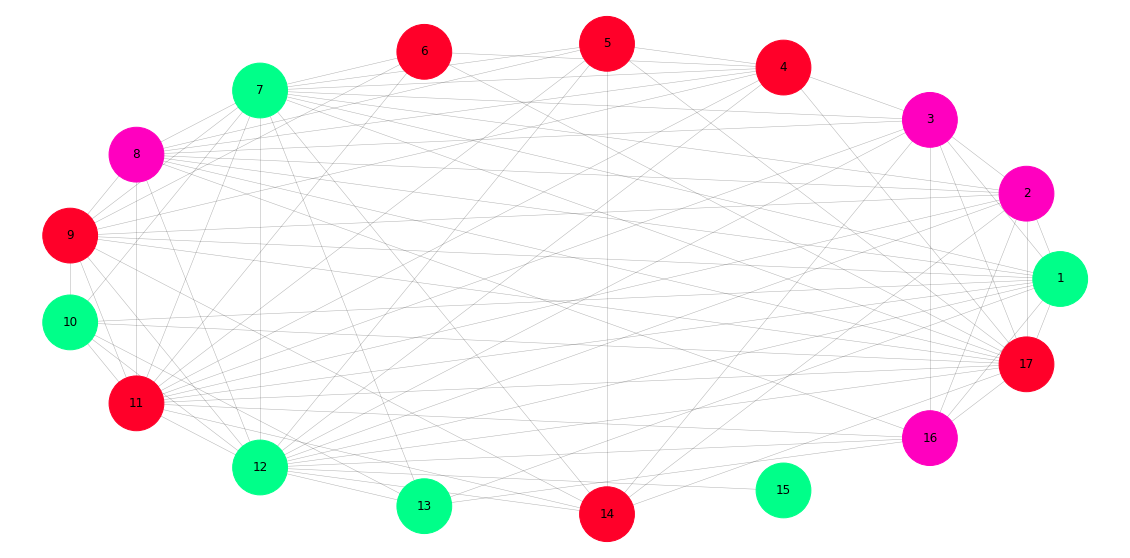

In [225]:
#Compute the greedy modularity maximisation and get the partition of the graph
G_as = nx.Graph(Adj2_as)
pos_as = nx.circular_layout(G_as)
c_as = list(greedy_modularity_communities(G_as))  
k_star_as = len(c_as)    #get the number of communities
print('The optimal number k* of communities is', k_star_as)

partitions_as = [list(x) for x in c_as]  #create an array with lists of the nodes in each community

#plot
plot_communities_nx(G_as, partitions_as, k_star_as, pos_as)

The optimal number k* of communities is 4


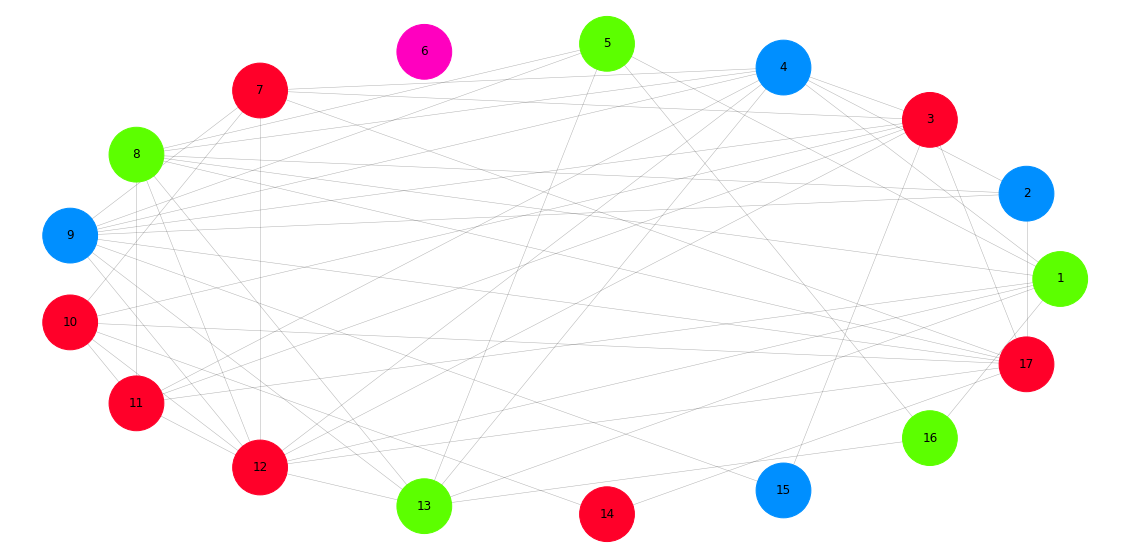

In [226]:
#Compute the greedy modularity maximisation and get the partition of the graph
G_af = nx.Graph(Adj2_af)
pos_af = nx.circular_layout(G_am)
c_af = list(greedy_modularity_communities(G_af))  
k_star_af = len(c_af)    #get the number of communities
print('The optimal number k* of communities is', k_star_af)

partitions_af = [list(x) for x in c_af]  #create an array with lists of the nodes in each community

#plot
plot_communities_nx(G_af, partitions_af, k_star_af, pos_af)

The optimal number k* of communities is 3


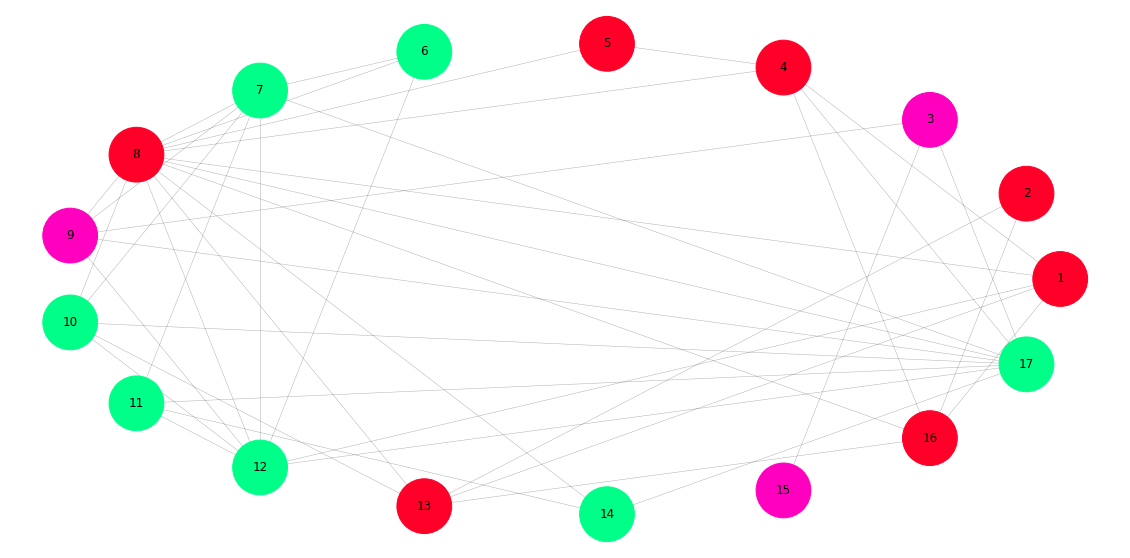

In [217]:
#Compute the greedy modularity maximisation and get the partition of the graph
G_am = nx.Graph(Adj2_am)
pos_am = nx.circular_layout(G_am)
c_am = list(greedy_modularity_communities(G_am))  
k_star_am = len(c_am)    #get the number of communities
print('The optimal number k* of communities is', k_star_am)

partitions_am = [list(x) for x in c_am]  #create an array with lists of the nodes in each community

#plot
plot_communities_nx(G_am, partitions_am, k_star_am, pos_am)

In [161]:
import scipy as sc
import scipy.sparse as sp

100%|██████████| 50/50 [00:00<00:00, 204.47it/s]


<Figure size 576x576 with 0 Axes>

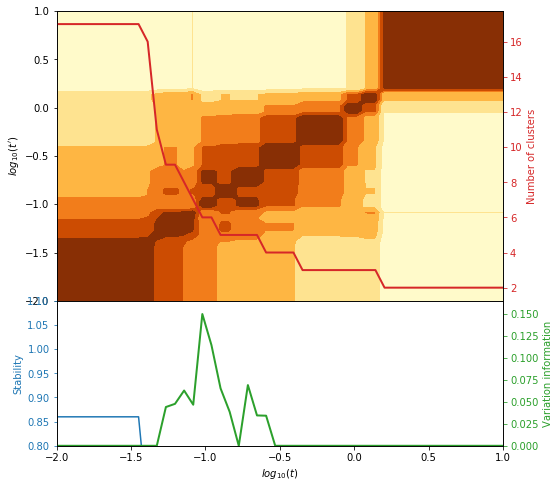

<Figure size 576x576 with 0 Axes>

In [218]:
A_am = sp.csr_matrix(Adj2_am)

results_projected_am = pgs.run(A_am, min_time=-2, max_time=1, n_time=50, constructor='continuous_combinatorial')
plotting.plot_scan(results_projected_am)
plt.figure()

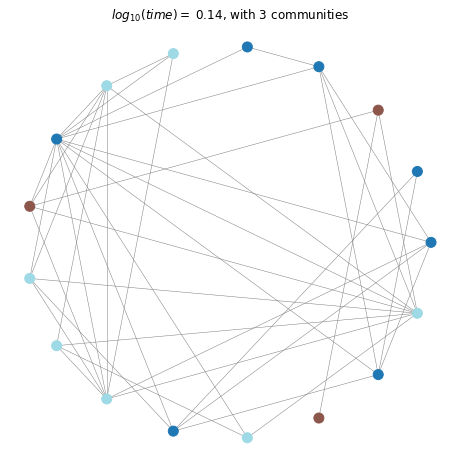

In [265]:
for u in G_am:
    G_am.nodes[u]["pos"] = pos_am[u]

plotting.plot_single_community(G_am, results_projected_am,35)

In [208]:
results_projected_am["community_id"][35]

array([0, 0, 1, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2])

100%|██████████| 50/50 [00:00<00:00, 251.98it/s]


<Figure size 576x576 with 0 Axes>

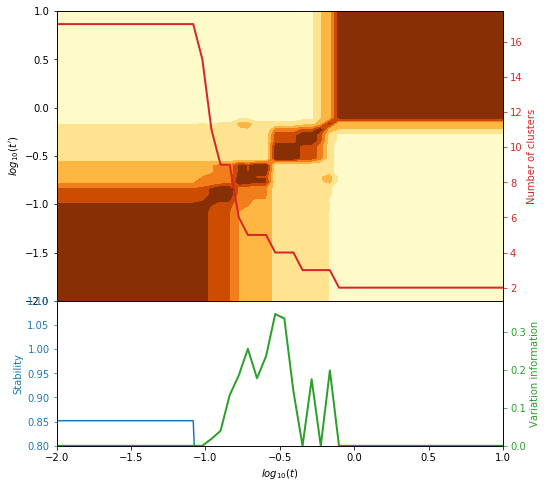

<Figure size 576x576 with 0 Axes>

In [223]:
A_as = sp.csr_matrix(Adj2_as)

results_projected_as = pgs.run(A_as, min_time=-2, max_time=1, n_time=50, constructor='continuous_combinatorial')
plotting.plot_scan(results_projected_as)
plt.figure()

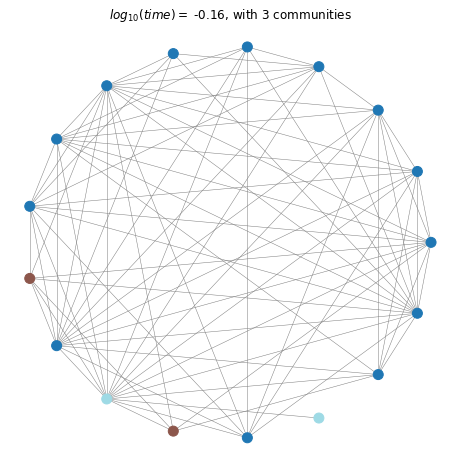

In [266]:
for u in G_as:
    G_as.nodes[u]["pos"] = pos_as[u]

plotting.plot_single_community(G_as, results_projected_as,30)

In [230]:
results_projected_as["community_id"][31]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [231]:
partitions_as

[[3, 4, 5, 8, 10, 13, 16], [0, 6, 9, 11, 12, 14], [1, 2, 7, 15]]

In [258]:
I_am = Ham.incidence_matrix().toarray()

In [259]:
H_am = np.matmul(I_am, I_am.T)
np.fill_diagonal(H_am,0)
H_am

array([[ 0,  1,  2,  4,  1,  3,  3,  2,  1,  1,  1,  1,  1,  0,  1,  1,
         3],
       [ 1,  0,  3,  5,  0,  5,  1,  3,  1,  0,  2,  1,  1,  1,  0,  2,
         3],
       [ 2,  3,  0,  5,  0,  9,  2, 10,  2,  0,  0,  1,  0,  0,  0,  1,
         5],
       [ 4,  5,  5,  0,  1, 10,  8,  5,  1,  1,  8,  5,  2,  2,  1,  8,
         8],
       [ 1,  0,  0,  1,  0,  0,  2,  1,  1,  1,  3,  2,  1,  1,  1,  1,
         1],
       [ 3,  5,  9, 10,  0,  0,  5, 10,  3,  1,  4,  4,  1,  1,  1,  4,
         9],
       [ 3,  1,  2,  8,  2,  5,  0,  3,  0,  3,  7,  6,  1,  1,  2,  2,
         4],
       [ 2,  3, 10,  5,  1, 10,  3,  0,  2,  1,  1,  4,  1,  1,  1,  0,
         6],
       [ 1,  1,  2,  1,  1,  3,  0,  2,  0,  0,  0,  0,  1,  0,  0,  0,
         2],
       [ 1,  0,  0,  1,  1,  1,  3,  1,  0,  0,  3,  2,  1,  1,  1,  0,
         1],
       [ 1,  2,  0,  8,  3,  4,  7,  1,  0,  3,  0,  5,  1,  4,  1,  3,
         4],
       [ 1,  1,  1,  5,  2,  4,  6,  4,  0,  2,  5,  0,  1,  1,  

100%|██████████| 50/50 [00:00<00:00, 256.23it/s]


<Figure size 576x576 with 0 Axes>

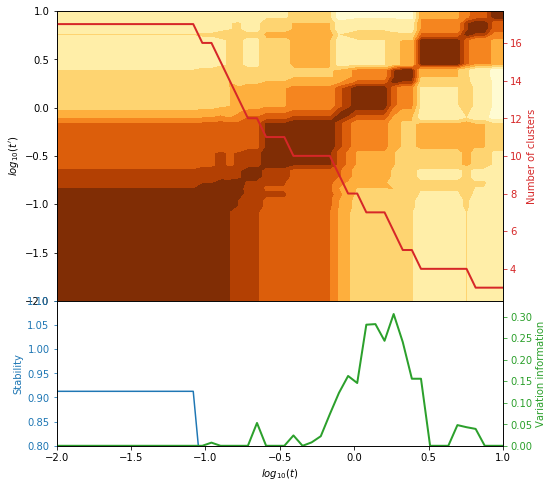

<Figure size 576x576 with 0 Axes>

In [260]:
H_am = sp.csr_matrix(H_am)
H_am = H_am.astype(np.float64)

results_projected_H_am = pgs.run(H_am, min_time=-2, max_time=1, n_time=50, constructor='continuous_combinatorial')
plotting.plot_scan(results_projected_H_am)
plt.figure()

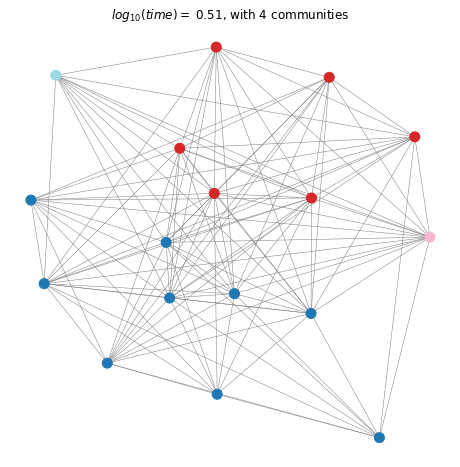

In [263]:
# construct network object just for plotting
g_am = nx.Graph(H_am)
pos_g_am = nx.spring_layout(g_am)
for u in g_am:
    g_am.nodes[u]["pos"] = pos_g_am[u]

    
plotting.plot_single_community(g_am, results_projected_H_am,41)

In [262]:
results_projected_H_am["community_id"][41]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 3, 0, 0])

## Trying different visualisations of hypergraphs

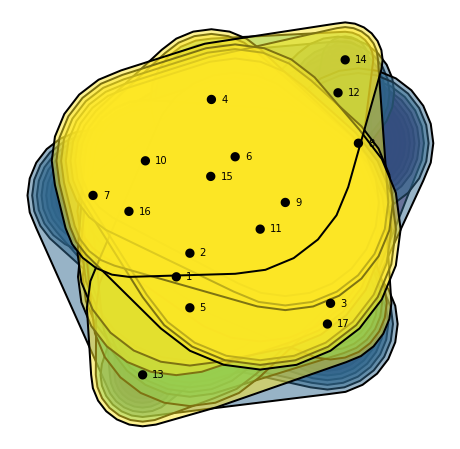

In [54]:
#Trying out different visualizations
cmap = plt.cm.viridis
alpha = .5

sizes = np.array([len(e) for e in Ham.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

hnx.drawing.draw(Ham,
                 label_alpha=0,
                 edges_kwargs={
                     'facecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
                     'edgecolors': 'black',
                     'linewidths': 2
                 }, with_edge_labels=False)

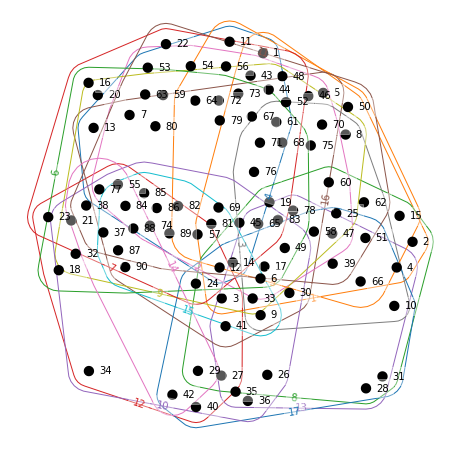

In [55]:
HD = Ham.dual()
hnx.draw(HD)

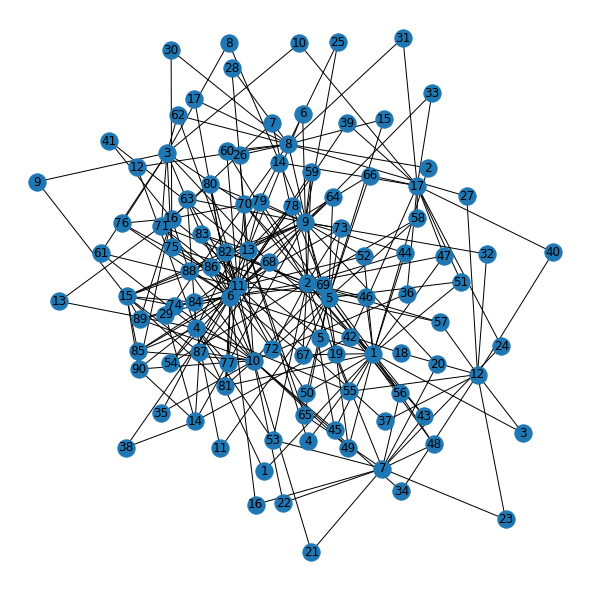

In [56]:
BH = Ham.bipartite()
nx.draw(BH, with_labels=True)

In [57]:
nodes_n = list(['{}'.format(i+1) for i in range(17)]) 
deg = nx.algorithms.bipartite.centrality.degree_centrality(BH, nodes=nodes_n) 

In [58]:
deg

{'4': 0.14444444444444446,
 '16': 0.13333333333333333,
 '15': 0.12222222222222223,
 '11': 0.3111111111111111,
 '17': 0.14444444444444446,
 '6': 0.2555555555555556,
 '2': 0.24444444444444446,
 '10': 0.2,
 '14': 0.06666666666666667,
 '7': 0.13333333333333333,
 '5': 0.22222222222222224,
 '1': 0.2111111111111111,
 '8': 0.15555555555555556,
 '13': 0.1,
 '12': 0.11111111111111112,
 '3': 0.12222222222222223,
 '9': 0.23333333333333334,
 1: 0.11764705882352941,
 2: 0.11764705882352941,
 3: 0.11764705882352941,
 4: 0.11764705882352941,
 5: 0.11764705882352941,
 6: 0.11764705882352941,
 7: 0.11764705882352941,
 8: 0.11764705882352941,
 9: 0.11764705882352941,
 10: 0.11764705882352941,
 11: 0.11764705882352941,
 12: 0.11764705882352941,
 13: 0.11764705882352941,
 14: 0.11764705882352941,
 15: 0.11764705882352941,
 16: 0.11764705882352941,
 17: 0.11764705882352941,
 18: 0.11764705882352941,
 19: 0.11764705882352941,
 20: 0.11764705882352941,
 21: 0.11764705882352941,
 22: 0.11764705882352941,
 23: 

In [59]:
M_ad = Ham.adjacency_matrix(s=1)
M_ad.toarray()

array([[ 0,  1,  2,  4,  1,  3,  3,  2,  1,  1,  1,  1,  1,  0,  1,  1,
         3],
       [ 1,  0,  3,  5,  0,  5,  1,  3,  1,  0,  2,  1,  1,  1,  0,  2,
         3],
       [ 2,  3,  0,  5,  0,  9,  2, 10,  2,  0,  0,  1,  0,  0,  0,  1,
         5],
       [ 4,  5,  5,  0,  1, 10,  8,  5,  1,  1,  8,  5,  2,  2,  1,  8,
         8],
       [ 1,  0,  0,  1,  0,  0,  2,  1,  1,  1,  3,  2,  1,  1,  1,  1,
         1],
       [ 3,  5,  9, 10,  0,  0,  5, 10,  3,  1,  4,  4,  1,  1,  1,  4,
         9],
       [ 3,  1,  2,  8,  2,  5,  0,  3,  0,  3,  7,  6,  1,  1,  2,  2,
         4],
       [ 2,  3, 10,  5,  1, 10,  3,  0,  2,  1,  1,  4,  1,  1,  1,  0,
         6],
       [ 1,  1,  2,  1,  1,  3,  0,  2,  0,  0,  0,  0,  1,  0,  0,  0,
         2],
       [ 1,  0,  0,  1,  1,  1,  3,  1,  0,  0,  3,  2,  1,  1,  1,  0,
         1],
       [ 1,  2,  0,  8,  3,  4,  7,  1,  0,  3,  0,  5,  1,  4,  1,  3,
         4],
       [ 1,  1,  1,  5,  2,  4,  6,  4,  0,  2,  5,  0,  1,  1,  

In [60]:
M_ad.toarray().shape

(17, 17)

In [61]:
Ham.degree('17', s=1)

13

In [62]:
Ham.degree('17', s=2)

13

In [63]:
Ham.degree('17', s=3)

4

In [64]:
Ham.degree('17', s=4)

0

In [65]:
Ham.degree('15', s=2)

11

In [66]:
Ham.degree('15', s=3)

10

In [67]:
Ham.degree('15', s=4)

10

In [68]:
degrees_2 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_2[node]= Ham.degree(node, s=2)
degrees_2

{'1': 19,
 '2': 22,
 '3': 11,
 '4': 13,
 '5': 20,
 '6': 23,
 '7': 12,
 '8': 14,
 '9': 21,
 '10': 18,
 '11': 28,
 '12': 10,
 '13': 9,
 '14': 6,
 '15': 11,
 '16': 12,
 '17': 13}

In [69]:
degrees_3 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_3[node]= Ham.degree(node, s=3)
degrees_3

{'1': 14,
 '2': 20,
 '3': 8,
 '4': 8,
 '5': 18,
 '6': 20,
 '7': 5,
 '8': 2,
 '9': 16,
 '10': 13,
 '11': 24,
 '12': 2,
 '13': 4,
 '14': 3,
 '15': 10,
 '16': 7,
 '17': 4}

In [70]:
# As with any iterator you can get all of the values in a list
list(Ham.neighbors('6'))

['15',
 '11',
 '2',
 '14',
 '7',
 '5',
 '16',
 '4',
 '10',
 '8',
 '1',
 '13',
 '12',
 '3',
 '9']

## Experiments on Target level

In [71]:
# data preparation
continents_prep_t = {}
continents_prep_t_K = {}

for continent in continents:
    print(continent)
    
    continents_prep_t[continent] = np.empty(76, dtype=object)
    continents_prep_t_K[continent] = np.empty(76, dtype=object)
    
    for t, target in enumerate(targets):
        t_list = []
        for country in continents[continent].dropna():
            t_list.append(np.asarray(targets_values_i[country][t]))
        
        t_array = np.asarray(t_list)
        continents_prep_t[continent][t] = t_array
        
        K_matrix = pairwise_kernels(t_array, metric='rbf', gamma=0.5/(width(t_array)**2))
        continents_prep_t_K[continent][t] = K_matrix

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [73]:
# save this data
f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_t.pkl', 'wb')
pickle.dump(continents_prep_t, f)
f.close()

f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_t_K.pkl', 'wb')
pickle.dump(continents_prep_t_K, f)
f.close()


In [ ]:
# CHECKPOINT
continents_prep_t = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_t.pkl', 'rb'))
continents_prep_t_K = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_t_K.pkl', 'rb'))

In [74]:
edges_e_t, Adj2_e_t = dHSIC_links_MC('Europe', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  999


In [75]:
edges_af_t, Adj2_af_t = dHSIC_links_MC('Africa', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  448


In [76]:
edges_as_t, Adj2_as_t = dHSIC_links_MC('Asia', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  694


In [77]:
edges_am_t, Adj2_am_t = dHSIC_links_MC('Americas', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  451


# Other Visualizations

In [300]:
dict_all_std = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dict_all_wb_std.pkl', 'rb'))
dict_all_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dict_all_i_wb.pkl', 'rb'))

In [ ]:
info = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None, dtype=str)
info.drop_duplicates(subset=[2], inplace=True)

In [309]:
targets = list(info[4].unique())
targets.remove('T')

dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [310]:
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

In [327]:
dict_all_std['France'].loc[dict_targets['3.2']]

TimePeriod          1990      1991      1992      1993      1994      1995  \
SH.DYN.MORT     2.637201  2.350809  1.992817  1.563228  1.205237  0.847246   
SH.DYN.MORT.FE  2.664910  2.313107  1.961303  1.609500  1.169746  0.905894   
SH.DYN.MORT.MA  2.601825  2.357713  1.991545  1.625378  1.198182  0.832014   
SH.DYN.NMRT     2.488898  1.951726  1.414554  1.145967  1.145967  1.145967   

TimePeriod          1996      1997      1998      1999  ...      2010  \
SH.DYN.MORT     0.560853  0.346058  0.202862  0.131263  ... -0.727915   
SH.DYN.MORT.FE  0.554090  0.378189  0.202287  0.114336  ... -0.765172   
SH.DYN.MORT.MA  0.587903  0.343791  0.221735  0.099679  ... -0.754712   
SH.DYN.NMRT     1.145967  0.877381  0.608795  0.340209  ... -1.002722   

TimePeriod          2011      2012      2013      2014      2015      2016  \
SH.DYN.MORT    -0.799514 -0.799514 -0.871112 -0.871112 -0.871112 -0.799514   
SH.DYN.MORT.FE -0.765172 -0.765172 -0.853123 -0.853123 -0.853123 -0.765172   
SH.DYN.MORT.MA -0.754712 -0.815740 -0.815740 -0.876768 -0.876768 -0.815740   
SH.DYN.NMRT    -1.271308 -1.271308 -1.002722 -0.734135 -0.734135 -0.734135   

TimePeriod          2017      2018      2019  
SH.DYN.MORT    -0.727915 -0.656317 -0.584719  
SH.DYN.MORT.FE -0.765172 -0.677221 -0.589271  
SH.DYN.MORT.MA -0.754712 -0.693684 -0.632656  
SH.DYN.NMRT    -0.465549 -0.196963  0.071623  

[4 rows x 30 columns]

In [313]:
dict_targets['1.2'][0]

'SI.POV.MDIM'

In [328]:
dict_all_std['Spain'].loc[dict_targets['3.2']]

TimePeriod          1990      1991      1992      1993      1994      1995  \
SH.DYN.MORT     2.275389  2.046323  1.817257  1.530925  1.301859  1.015526   
SH.DYN.MORT.FE  2.287785  2.030006  1.772228  1.578894  1.256670  0.998892   
SH.DYN.MORT.MA  2.310877  2.054682  1.798487  1.542292  1.286098  1.029903   
SH.DYN.NMRT     2.426035  2.200707  1.862715  1.524722  1.186729  1.074065   

TimePeriod          1996      1997      1998      1999  ...      2010  \
SH.DYN.MORT     0.786460  0.557394  0.442861  0.271061  ... -0.759736   
SH.DYN.MORT.FE  0.805558  0.612224  0.418890  0.290001  ... -0.741113   
SH.DYN.MORT.MA  0.773708  0.568752  0.415035  0.261319  ... -0.712221   
SH.DYN.NMRT     0.848737  0.510744  0.285416  0.172752  ... -0.728562   

TimePeriod          2011      2012      2013      2014      2015      2016  \
SH.DYN.MORT    -0.817002 -0.874269 -0.931535 -0.988802 -1.046068 -1.103335   
SH.DYN.MORT.FE -0.805558 -0.870003 -0.934447 -0.998892 -1.063337 -1.063337   
SH.DYN.MORT.MA -0.814699 -0.865938 -0.968416 -1.019655 -1.019655 -1.070894   
SH.DYN.NMRT    -0.728562 -0.728562 -0.841226 -0.841226 -0.953890 -0.953890   

TimePeriod          2017      2018      2019  
SH.DYN.MORT    -1.103335 -1.103335 -1.160601  
SH.DYN.MORT.FE -1.127781 -1.127781 -1.192226  
SH.DYN.MORT.MA -1.070894 -1.122133 -1.122133  
SH.DYN.NMRT    -0.953890 -1.066554 -1.066554  

[4 rows x 30 columns]

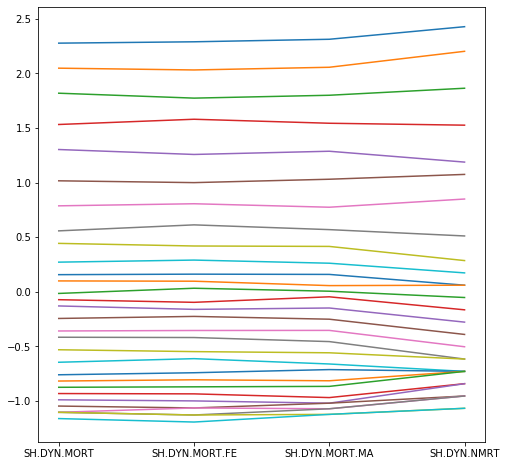

In [329]:
plt.plot(dict_all_std['Spain'].loc[dict_targets['3.2']])